In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.datasets import make_classification

from sklearn import cross_validation
from sklearn.metrics import accuracy_score,f1_score
import math

In [90]:
import warnings; warnings.simplefilter('ignore')

## Applying randomized optimization algorithms to a Multi-layer perceptron

### Cosntruct the MLP class with 1 hidden layer which has following parameters and methods
* Hidden layer size i.e. number of neurons
* Choice of the optimization method for gradient based methods
* Parameter for random weight initialization
* **`Fit()`** method for gradient (Jacobian) and 2nd-derivative (Hessian) based optimization techniques
* **`Fit_simplex()`** method for optimization through simple downhill descent (***derivative-free***)
* **`Fit_anneal()`** method for optimization through simulated annealing (***derivative-free***)
* **`Fit_de()`** method for optimization through differential evolution (from **genetic algorithm** class) (***derivative-free***) 

In [91]:
class NN_1HL(object):

    def __init__(self, reg_lambda=0, epsilon_init=0.12, hidden_layer_size=25, opti_method='TNC', maxiter=500):
        self.reg_lambda = reg_lambda
        self.epsilon_init = epsilon_init
        self.hidden_layer_size = hidden_layer_size
        self.activation_func = self.sigmoid
        self.activation_func_prime = self.sigmoid_prime
        self.method = opti_method
        self.maxiter = maxiter

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_prime(self, z):
        sig = self.sigmoid(z)
        return sig * (1 - sig)

    def sumsqr(self, a):
        return np.sum(a ** 2)

    def rand_init(self, l_in, l_out):
        self.epsilon_init = (math.sqrt(6))/(math.sqrt(l_in + l_out))
        return np.random.rand(l_out, l_in + 1) * 2 * self.epsilon_init - self.epsilon_init

    def pack_thetas(self, t1, t2):
        return np.concatenate((t1.reshape(-1), t2.reshape(-1)))

    def unpack_thetas(self, thetas, input_layer_size, hidden_layer_size, num_labels):
        t1_start = 0
        t1_end = hidden_layer_size * (input_layer_size + 1)
        t1 = thetas[t1_start:t1_end].reshape((hidden_layer_size, input_layer_size + 1))
        t2 = thetas[t1_end:].reshape((num_labels, hidden_layer_size + 1))
        return t1, t2

    def _forward(self, X, t1, t2):
        m = X.shape[0]
        ones = None
        if len(X.shape) == 1:
            ones = np.array(1).reshape(1,)
        else:
            ones = np.ones(m).reshape(m,1)

        # Input layer
        a1 = np.hstack((ones, X))

        # Hidden Layer
        z2 = np.dot(t1, a1.T)
        a2 = self.activation_func(z2)
        a2 = np.hstack((ones, a2.T))

        # Output layer
        z3 = np.dot(t2, a2.T)
        a3 = self.activation_func(z3)
        return a1, z2, a2, z3, a3

    def function(self, thetas, input_layer_size, hidden_layer_size, num_labels, X, y, reg_lambda):
        t1, t2 = self.unpack_thetas(thetas, input_layer_size, hidden_layer_size, num_labels)

        m = X.shape[0]
        Y = np.eye(num_labels)[y]

        _, _, _, _, h = self._forward(X, t1, t2)
        costPositive = -Y * np.log(h).T
        costNegative = (1 - Y) * np.log(1 - h).T
        cost = costPositive - costNegative
        J = np.sum(cost) / m

        if reg_lambda != 0:
            t1f = t1[:, 1:]
            t2f = t2[:, 1:]
            reg = (self.reg_lambda / (2 * m)) * (self.sumsqr(t1f) + self.sumsqr(t2f))
            J = J + reg
        return J

    def function_prime(self, thetas, input_layer_size, hidden_layer_size, num_labels, X, y, reg_lambda):
        t1, t2 = self.unpack_thetas(thetas, input_layer_size, hidden_layer_size, num_labels)

        m = X.shape[0]
        t1f = t1[:, 1:]
        t2f = t2[:, 1:]
        Y = np.eye(num_labels)[y]

        Delta1, Delta2 = 0, 0
        for i, row in enumerate(X):
            a1, z2, a2, z3, a3 = self._forward(row, t1, t2)

            # Backprop
            d3 = a3 - Y[i, :].T
            d2 = np.dot(t2f.T, d3) * self.activation_func_prime(z2)

            Delta2 += np.dot(d3[np.newaxis].T, a2[np.newaxis])
            Delta1 += np.dot(d2[np.newaxis].T, a1[np.newaxis])

        Theta1_grad = (1 / m) * Delta1
        Theta2_grad = (1 / m) * Delta2

        if reg_lambda != 0:
            Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (reg_lambda / m) * t1f
            Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (reg_lambda / m) * t2f

        return self.pack_thetas(Theta1_grad, Theta2_grad)

    def fit(self, X, y):
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))

        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)

        options = {'maxiter': self.maxiter}
        _res = optimize.minimize(self.function, thetas0, jac=self.function_prime, method=self.method, 
                                 args=(input_layer_size, self.hidden_layer_size, num_labels, X, y, 0), 
                                 options=options)
        
        #print(_res)

        self.t1, self.t2 = self.unpack_thetas(_res.x, input_layer_size, self.hidden_layer_size, num_labels)

        np.savetxt("weights_t1.txt", self.t1, newline="\n")
        np.savetxt("weights_t2.txt", self.t2, newline="\n")
        
    def fit_simplex(self, X, y,status=False):
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))

        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)

        options = {'maxiter': self.maxiter}
        _res = optimize.fmin(self.function, thetas0, maxiter=self.maxiter,disp=status,
                            args=(input_layer_size, self.hidden_layer_size, num_labels, X, y, 0))
        
        _res=np.array(_res)
        if status:
            print(_res)

        self.t1, self.t2 = self.unpack_thetas(_res, input_layer_size, self.hidden_layer_size, num_labels)

        np.savetxt("weights_t1.txt", self.t1, newline="\n")
        np.savetxt("weights_t2.txt", self.t2, newline="\n")
        
    def fit_anneal(self, X, y,temp=None,status=False):
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))

        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)

        options = {'maxiter': self.maxiter}
        
        if temp!=None:
            model_T=temp
        
        _res = optimize.basinhopping(self.function, thetas0, niter=self.maxiter,T=model_T,disp=status,
                                    minimizer_kwargs={'args':(input_layer_size, self.hidden_layer_size, 
                                                              num_labels, X, y, 0)})
        
        if status:
            print(_res)

        self.t1, self.t2 = self.unpack_thetas(_res.x, input_layer_size, self.hidden_layer_size, num_labels)

        np.savetxt("weights_t1.txt", self.t1, newline="\n")
        np.savetxt("weights_t2.txt", self.t2, newline="\n")
        
    def fit_de(self, X, y,bound=10,status=False,strategy='best1bin',popsize=10,mutation=(0.5,1.0),
              recombination=0.7,init='latinhypercube'):
        """
        Fits a differential evolution algorithm
        bound: Bounds for variables
        """
        num_features = X.shape[0]
        input_layer_size = X.shape[1]
        num_labels = len(set(y))

        theta1_0 = self.rand_init(input_layer_size, self.hidden_layer_size)
        theta2_0 = self.rand_init(self.hidden_layer_size, num_labels)
        thetas0 = self.pack_thetas(theta1_0, theta2_0)

        options = {'maxiter': self.maxiter}
        
        _res = optimize.differential_evolution(self.function, bounds=[(-bound,bound)]*len(thetas0), 
                                               maxiter=self.maxiter, disp=status,
                                    args=(input_layer_size, self.hidden_layer_size,num_labels, X, y, 0))
        
        if status:
            print(_res)

        self.t1, self.t2 = self.unpack_thetas(_res.x, input_layer_size, self.hidden_layer_size, num_labels)

        np.savetxt("weights_t1.txt", self.t1, newline="\n")
        np.savetxt("weights_t2.txt", self.t2, newline="\n")

    def predict(self, X):
        return self.predict_proba(X).argmax(0)

    def predict_proba(self, X):
        _, _, _, _, h = self._forward(X, self.t1, self.t2)
        return h

### For test - create some synthetic data

In [132]:
data = make_classification(n_samples=500,n_features=10,n_informative=8,
                           n_classes=2,n_redundant=2,class_sep=0.5,flip_y=0.1)

In [133]:
features=data[0]
response=data[1]
full_data=np.column_stack((features,response))

In [135]:
df=pd.DataFrame(full_data,columns=['X'+str(i) for i in range(10)]+['y'])

In [136]:
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,y
0,-0.707228,-0.091718,1.366142,-1.638905,1.034314,0.457061,-1.125703,-1.403976,2.001021,1.262102,0.0
1,-0.247779,-1.254694,0.896102,0.053484,2.040638,0.969665,-0.085845,1.175116,2.393979,0.748807,0.0
2,-1.801084,1.371932,0.601973,0.110634,-2.366770,-0.918567,1.171675,-1.508922,-1.641504,-4.077089,0.0
3,0.277573,0.200249,-0.115067,0.330957,0.947562,1.615095,1.830136,0.062748,0.068971,-1.414749,0.0
4,0.614410,1.346785,-2.018468,0.905438,0.385929,-0.662869,0.605764,-0.602145,-2.268239,-0.193403,0.0


### Visualize

We plot histograms, boxlots and scatterplots of the dataset and observe that the **class separation is not very obvious**. Particularly, boxplots show lot of overlap between features for two output classes.

So, this should be a **non-trivial classification task.**

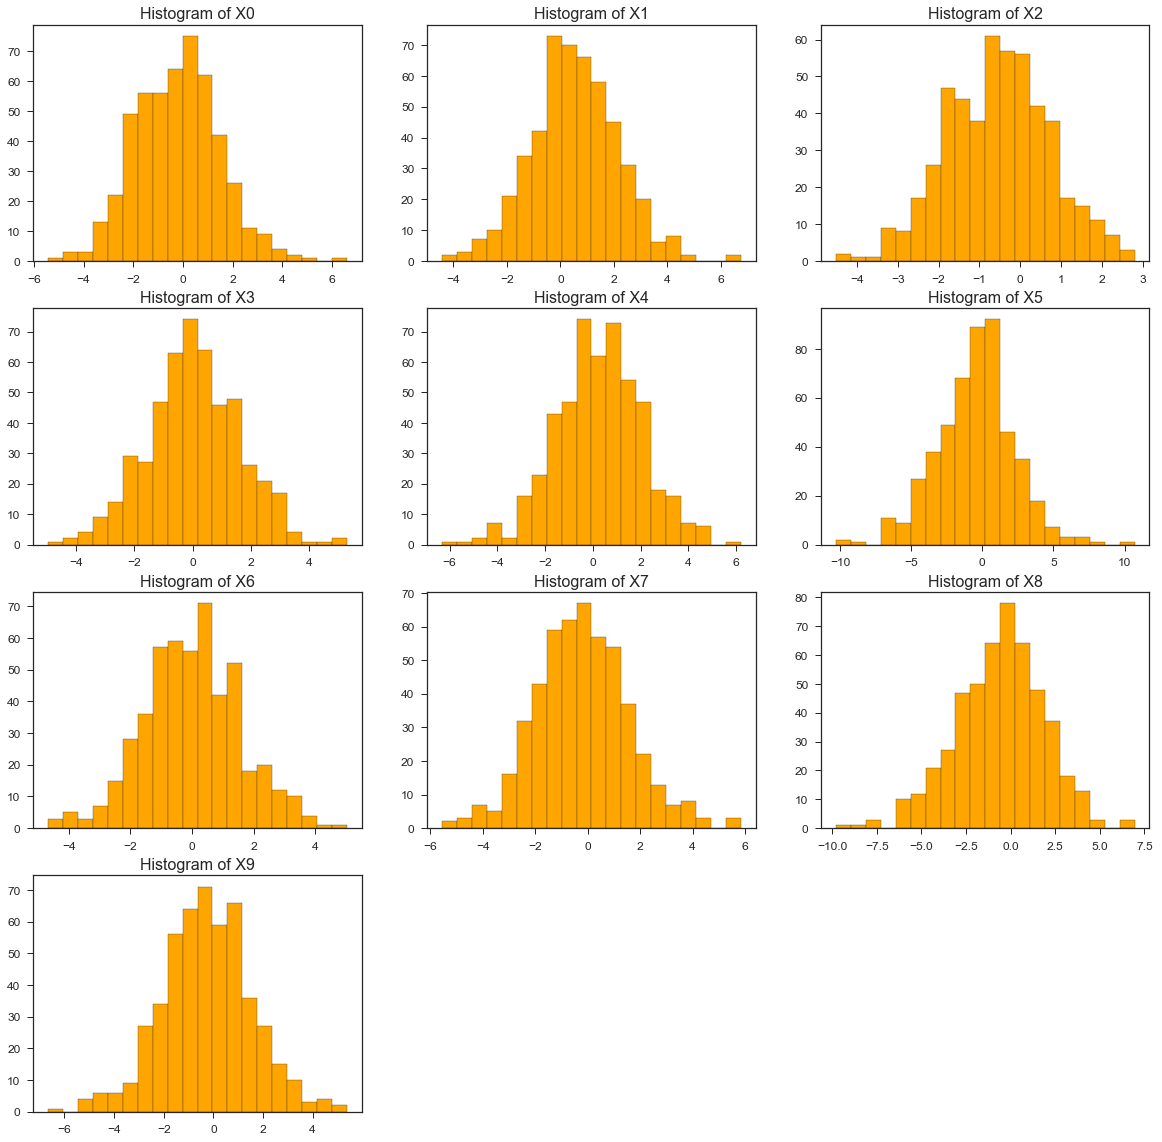

In [139]:
i=1
plt.figure(figsize=(20,20))
for c in df.describe().columns[:-1]:
    plt.subplot(4,3,i)
    plt.title(f"Histogram of {c}",fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.hist(df[c],bins=20,color='orange',edgecolor='k')
    i+=1
plt.show()

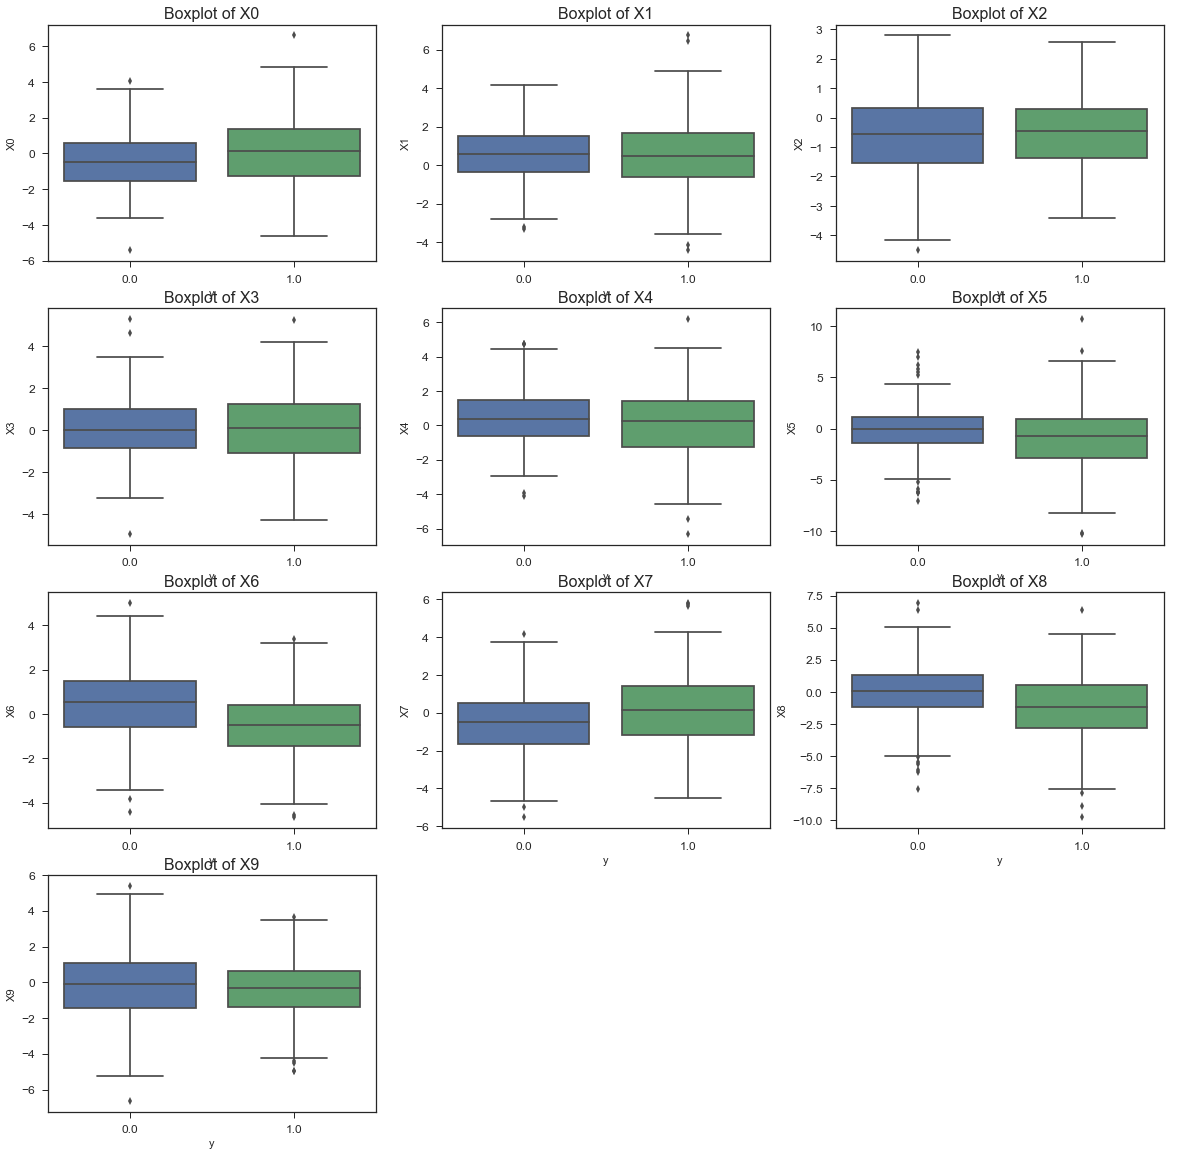

In [140]:
i=1
plt.figure(figsize=(20,20))
for c in df.columns[:-1]:
    plt.subplot(4,3,i)
    plt.title(f"Boxplot of {c}",fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    sns.boxplot(y=df[c],x=df['y'])
    i+=1
plt.show()

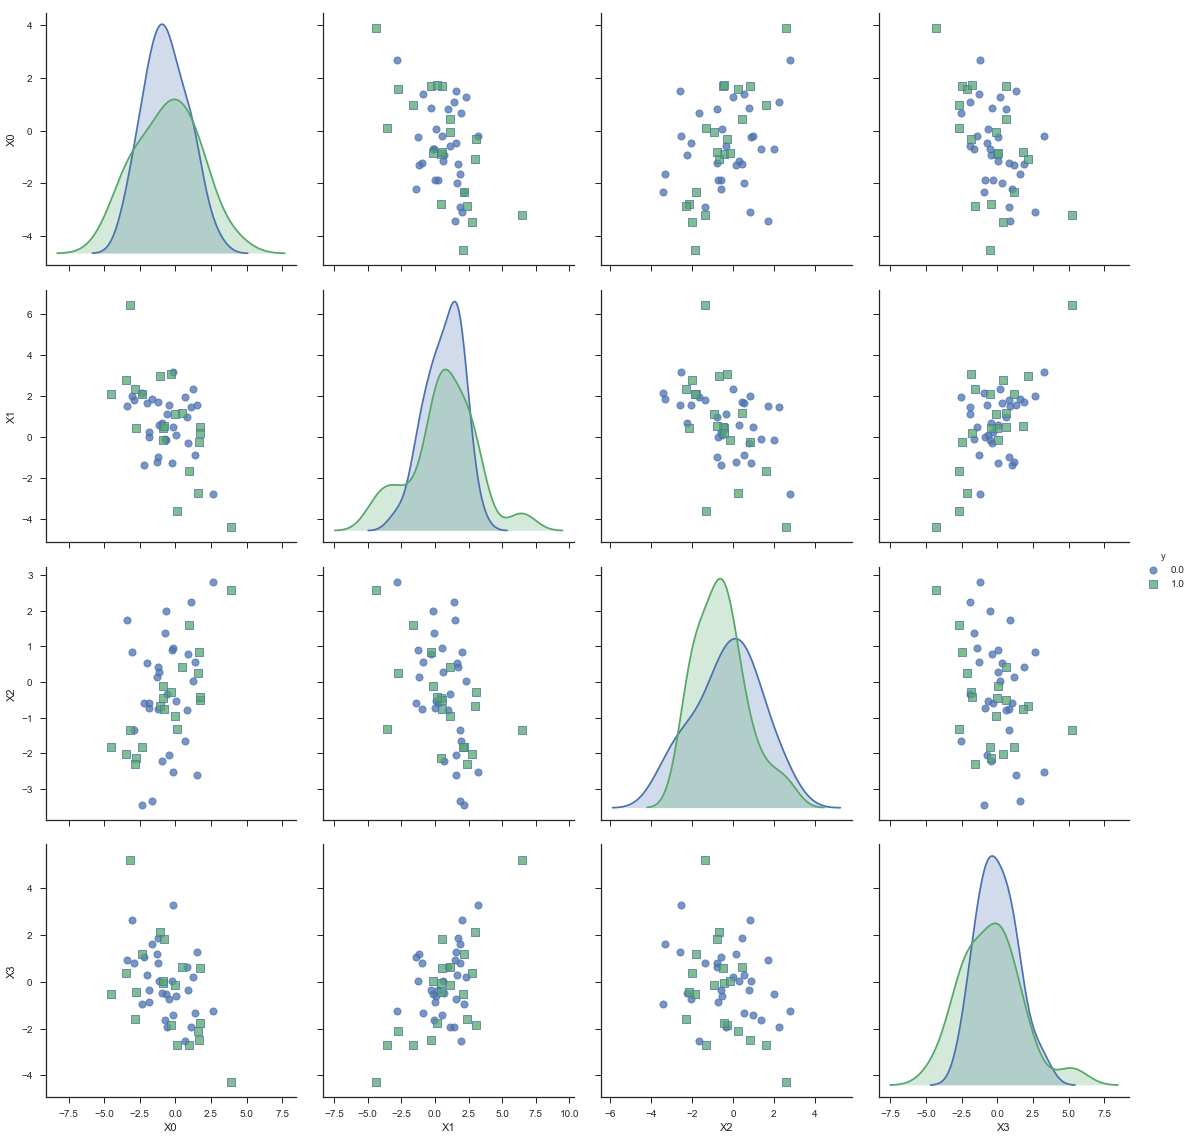

In [142]:
df_sample=df.sample(frac=0.1)
sns.set(style="ticks", color_codes=True)
g=sns.pairplot(df_sample,vars=['X0','X1','X2','X3'],
               plot_kws=dict(s=50, edgecolor="b", linewidth=1,alpha=0.75),
               hue="y",markers=["o", "s"], diag_kind="kde",diag_kws=dict(shade=True), size=4)

### Save the data in a text file

In [143]:
np.savetxt('scipy_test.txt',X=full_data,delimiter=', ')

### Read the data from the file

In [154]:
values = np.loadtxt('scipy_test.txt', delimiter=', ', usecols=[i for i in range(10)])
targets = np.loadtxt('scipy_test.txt', delimiter=', ', dtype=(int), usecols=[10])

### Standard scaling and min/max scaling

In [155]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [156]:
sc=StandardScaler()
mms = MinMaxScaler()

In [157]:
values_scaled=sc.fit_transform(values)
values_minmax=mms.fit_transform(values)

In [158]:
values_scaled[1:10]

array([[-0.02336662, -1.10305152,  1.1348675 , -0.00997047,  0.9909208 ,
         0.52509456, -0.07286128,  0.77479087,  1.20778891,  0.56295375],
       [-0.9453038 ,  0.50330277,  0.90160291,  0.02612856, -1.46478606,
        -0.17655351,  0.73210276, -0.74273675, -0.42281069, -2.11823341],
       [ 0.28844674, -0.2132586 ,  0.33294116,  0.16529938,  0.3818842 ,
         0.76492983,  1.15359708,  0.14586924,  0.26833341, -0.63908186],
       [ 0.48837049,  0.4879234 , -1.17658531,  0.52817804,  0.06895476,
        -0.0815388 ,  0.36985153, -0.23005422, -0.67605258,  0.03947765],
       [-0.22857613,  1.79138869, -1.08796922,  1.67664022, -0.77962128,
        -1.34225446,  0.18207819,  0.01691665, -2.29022485, -1.87271876],
       [ 2.12280787, -0.88907603,  1.16287099, -0.47344758, -0.94916322,
         1.13575114,  0.06637992,  1.23824613, -0.53770964, -0.34110077],
       [-0.66736462, -0.36503344, -0.26898407, -0.95961223, -1.65198088,
        -0.55191583, -0.67808853,  0.86693437

In [159]:
values_minmax[1:10]

array([[0.43004367, 0.28338976, 0.73990009, 0.48848441, 0.66772841,
        0.5360601 , 0.47215067, 0.59054608, 0.72769615, 0.61507424],
       [0.30080193, 0.51870854, 0.69961466, 0.49407939, 0.31511017,
        0.44602385, 0.60195866, 0.35453066, 0.48649412, 0.21362289],
       [0.47375522, 0.41373771, 0.60140524, 0.51564942, 0.58027603,
        0.56683602, 0.66992856, 0.49273224, 0.58872974, 0.43509471],
       [0.50178153, 0.51645557, 0.34070593, 0.57189183, 0.53534207,
        0.45821624, 0.54354225, 0.43426627, 0.449034  , 0.53669472],
       [0.40127638, 0.7074034 , 0.35601017, 0.74989153, 0.4134939 ,
        0.29643983, 0.51326204, 0.47267673, 0.21026194, 0.25038355],
       [0.73090509, 0.31473555, 0.74473636, 0.41665028, 0.38914914,
        0.61442022, 0.49460462, 0.66262555, 0.469498  , 0.47971111],
       [0.33976482, 0.39150384, 0.49745112, 0.34129982, 0.28823061,
        0.39785695, 0.37455211, 0.60487682, 0.54509793, 0.49606117],
       [0.26554562, 0.3967031 , 0.6324377

### Train/test split

In [160]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(values, targets, test_size=0.4)

In [161]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = cross_validation.train_test_split(values_scaled, targets, test_size=0.4)

In [162]:
X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = cross_validation.train_test_split(values_minmax, targets, test_size=0.4)

### Fit with <span style=color:blue>simple hill climb (descent)</span> algorithm and show accuracy and F1 score

In [163]:
nn = NN_1HL(hidden_layer_size=5,maxiter=50000)
nn.fit_simplex(X_train, y_train)
print("Accuracy of classification: "+str(accuracy_score(y_test, nn.predict(X_test))))
print("F1 score of classification: "+str(f1_score(y_test, nn.predict(X_test))))

Accuracy of classification: 0.665
F1 score of classification: 0.5988023952095808


In [164]:
nn = NN_1HL(hidden_layer_size=5,maxiter=50000)
nn.fit_simplex(X_train_scaled, y_train_scaled)
print("Accuracy of classification: "+str(accuracy_score(y_test_scaled, nn.predict(X_test_scaled))))
print("F1 score of classification: "+str(f1_score(y_test_scaled, nn.predict(X_test_scaled))))

Accuracy of classification: 0.76
F1 score of classification: 0.7391304347826086


In [165]:
nn = NN_1HL(hidden_layer_size=5,maxiter=50000)
nn.fit_simplex(X_train_minmax, y_train_minmax)
print("Accuracy of classification: "+str(accuracy_score(y_test_minmax, nn.predict(X_test_minmax))))
print("F1 score of classification: "+str(f1_score(y_test_minmax, nn.predict(X_test_minmax))))

Accuracy of classification: 0.76
F1 score of classification: 0.7391304347826088


### Fit with <span style=color:blue>simulated annealing</span> algorithm and show accuracy and F1 score

In [169]:
nn = NN_1HL(hidden_layer_size=5,maxiter=20)
nn.fit_anneal(X_train, y_train,temp=10,status=True)
print("Accuracy of classification: "+str(accuracy_score(y_test, nn.predict(X_test))))
print("F1 score of classification: "+str(f1_score(y_test, nn.predict(X_test))))

basinhopping step 0: f 0.592075
basinhopping step 1: f 0.592074 trial_f 0.592074 accepted 1  lowest_f 0.592074
found new global minimum on step 1 with function value 0.592074
basinhopping step 2: f 0.592074 trial_f 0.592074 accepted 1  lowest_f 0.592074
found new global minimum on step 2 with function value 0.592074
basinhopping step 3: f 0.592074 trial_f 0.592074 accepted 1  lowest_f 0.592074
basinhopping step 4: f 0.592075 trial_f 0.592075 accepted 1  lowest_f 0.592074
basinhopping step 5: f 0.592074 trial_f 0.592074 accepted 1  lowest_f 0.592074
basinhopping step 6: f 0.592074 trial_f 0.592074 accepted 1  lowest_f 0.592074
found new global minimum on step 6 with function value 0.592074
basinhopping step 7: f 0.592074 trial_f 0.592074 accepted 1  lowest_f 0.592074
found new global minimum on step 7 with function value 0.592074
basinhopping step 8: f 0.592074 trial_f 0.592074 accepted 1  lowest_f 0.592074
basinhopping step 9: f 0.592074 trial_f 0.592074 accepted 1  lowest_f 0.592074
b

In [170]:
nn = NN_1HL(hidden_layer_size=5,maxiter=20)
nn.fit_anneal(X_train_scaled, y_train_scaled,temp=10)
print("Accuracy of classification: "+str(accuracy_score(y_test_scaled, nn.predict(X_test_scaled))))
print("F1 score of classification: "+str(f1_score(y_test_scaled, nn.predict(X_test_scaled))))

Accuracy of classification: 0.475
F1 score of classification: 0.5205479452054794


In [171]:
nn = NN_1HL(hidden_layer_size=5,maxiter=20)
nn.fit_anneal(X_train_minmax, y_train_minmax,temp=10)
print("Accuracy of classification: "+str(accuracy_score(y_test_minmax, nn.predict(X_test_minmax))))
print("F1 score of classification: "+str(f1_score(y_test_minmax, nn.predict(X_test_minmax))))

Accuracy of classification: 0.66
F1 score of classification: 0.46875


### Fit with <span style=color:blue>differential evolution</span> algorithm and show accuracy and F1 score

In [172]:
nn = NN_1HL(hidden_layer_size=5,maxiter=100)
nn.fit_de(X_train, y_train,bound=2,status=True)
print("Accuracy of classification: "+str(accuracy_score(y_test, nn.predict(X_test))))
print("F1 score of classification: "+str(f1_score(y_test, nn.predict(X_test))))

differential_evolution step 1: f(x)= 1.35419
differential_evolution step 2: f(x)= 1.33874
differential_evolution step 3: f(x)= 1.31077
differential_evolution step 4: f(x)= 1.31077
differential_evolution step 5: f(x)= 1.31077
differential_evolution step 6: f(x)= 1.31077
differential_evolution step 7: f(x)= 1.31077
differential_evolution step 8: f(x)= 1.31077
differential_evolution step 9: f(x)= 1.31077
differential_evolution step 10: f(x)= 1.30982
differential_evolution step 11: f(x)= 1.25436
differential_evolution step 12: f(x)= 1.25436
differential_evolution step 13: f(x)= 1.24287
differential_evolution step 14: f(x)= 1.24287
differential_evolution step 15: f(x)= 1.24287
differential_evolution step 16: f(x)= 1.20672
differential_evolution step 17: f(x)= 1.20672
differential_evolution step 18: f(x)= 1.20672
differential_evolution step 19: f(x)= 1.20672
differential_evolution step 20: f(x)= 1.20672
differential_evolution step 21: f(x)= 1.20672
differential_evolution step 22: f(x)= 1.206

In [173]:
nn = NN_1HL(hidden_layer_size=5,maxiter=100)
nn.fit_de(X_train_scaled, y_train_scaled,bound=2)
print("Accuracy of classification: "+str(accuracy_score(y_test_scaled, nn.predict(X_test_scaled))))
print("F1 score of classification: "+str(f1_score(y_test_scaled, nn.predict(X_test_scaled))))

Accuracy of classification: 0.745
F1 score of classification: 0.7272727272727273


In [174]:
nn = NN_1HL(hidden_layer_size=5,maxiter=100)
nn.fit_de(X_train_minmax, y_train_minmax,bound=2)
print("Accuracy of classification: "+str(accuracy_score(y_test_minmax, nn.predict(X_test_minmax))))
print("F1 score of classification: "+str(f1_score(y_test_minmax, nn.predict(X_test_minmax))))

Accuracy of classification: 0.785
F1 score of classification: 0.7624309392265194


### Try various optimization rotuines from `scipy.optimize()`

In [175]:
solvers=['BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']

In [176]:
for s in solvers:
    nn = NN_1HL(opti_method=s,maxiter=1000)
    nn.fit(X_train, y_train)
    print(f"Accuracy of classification: using {s}: "+str(accuracy_score(y_test, nn.predict(X_test))))
    print(f"F1-score of classification: using {s}: "+str(f1_score(y_test, nn.predict(X_test))))
    print("="*80)

Accuracy of classification: using BFGS: 0.735
F1-score of classification: using BFGS: 0.7282051282051282
Accuracy of classification: using L-BFGS-B: 0.735
F1-score of classification: using L-BFGS-B: 0.707182320441989
Accuracy of classification: using TNC: 0.765
F1-score of classification: using TNC: 0.7614213197969543
Accuracy of classification: using COBYLA: 0.72
F1-score of classification: using COBYLA: 0.6956521739130435
Accuracy of classification: using SLSQP: 0.745
F1-score of classification: using SLSQP: 0.7437185929648242


In [179]:
nn = NN_1HL(hidden_layer_size=5,maxiter=300)
nn.fit_de(X_train, y_train,bound=2,mutation=(0.1,1.2),popsize=50,recombination=0.3,status=True)
print("Accuracy of classification: "+str(accuracy_score(y_test, nn.predict(X_test))))
print("F1 score of classification: "+str(f1_score(y_test, nn.predict(X_test))))

differential_evolution step 1: f(x)= 1.35101
differential_evolution step 2: f(x)= 1.29903
differential_evolution step 3: f(x)= 1.29903
differential_evolution step 4: f(x)= 1.29167
differential_evolution step 5: f(x)= 1.29167
differential_evolution step 6: f(x)= 1.26922
differential_evolution step 7: f(x)= 1.26922
differential_evolution step 8: f(x)= 1.26922
differential_evolution step 9: f(x)= 1.26922
differential_evolution step 10: f(x)= 1.20417
differential_evolution step 11: f(x)= 1.20417
differential_evolution step 12: f(x)= 1.20417
differential_evolution step 13: f(x)= 1.20417
differential_evolution step 14: f(x)= 1.20417
differential_evolution step 15: f(x)= 1.20417
differential_evolution step 16: f(x)= 1.19774
differential_evolution step 17: f(x)= 1.19598
differential_evolution step 18: f(x)= 1.19598
differential_evolution step 19: f(x)= 1.19598
differential_evolution step 20: f(x)= 1.19598
differential_evolution step 21: f(x)= 1.19598
differential_evolution step 22: f(x)= 1.195

differential_evolution step 178: f(x)= 1.03504
differential_evolution step 179: f(x)= 1.03504
differential_evolution step 180: f(x)= 1.03504
differential_evolution step 181: f(x)= 1.03504
differential_evolution step 182: f(x)= 1.03504
differential_evolution step 183: f(x)= 1.03504
differential_evolution step 184: f(x)= 1.03504
differential_evolution step 185: f(x)= 1.03504
differential_evolution step 186: f(x)= 1.03504
differential_evolution step 187: f(x)= 1.03504
differential_evolution step 188: f(x)= 1.03504
differential_evolution step 189: f(x)= 1.03504
differential_evolution step 190: f(x)= 1.03504
differential_evolution step 191: f(x)= 1.03504
differential_evolution step 192: f(x)= 1.03095
differential_evolution step 193: f(x)= 1.02757
differential_evolution step 194: f(x)= 1.02757
differential_evolution step 195: f(x)= 1.02757
differential_evolution step 196: f(x)= 1.02757
differential_evolution step 197: f(x)= 1.02757
differential_evolution step 198: f(x)= 1.02757
differential_

## Deep neural net (using `keras`)

In [180]:
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [182]:
n_input=X_train.shape[0]
num_classes = 2
input_dim=X_train.shape[1]

### Function to construct 2-hidden-layer Keras model

In [226]:
def make_2layer_NN(input_dim, num_classes, neuron_layer_1=5, neuron_layer_2=5, dropout_prob=0.25, \
                  activation_func='relu', learning_rate=0.01,optimizer='SGD'):
    """
    Creates a 2-hidden-layer Keras Neural Network model by adding densely connected layers, \
    dropout layers, and an output layer with 'softmax' activation with appropriate number of nodes for classification
    """
    model = Sequential()
    model.add(Dense(neuron_layer_1, input_shape=(input_dim,),activation=activation_func))
    model.add(Dropout(dropout_prob))
    model.add(Dense(neuron_layer_2,activation=activation_func))
    model.add(Dropout(dropout_prob))
    # Softmax activation for the last layer for classification
    model.add(Dense(1, activation='sigmoid'))
    
    if optimizer=='SGD':
        optimizer=keras.optimizers.SGD(lr=learning_rate)
    if optimizer=='Adam':
        optimizer=keras.optimizers.Adam(lr=learning_rate)
    if optimizer=='RMSprop':
        optimizer=keras.optimizers.RMSprop(lr=learning_rate)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    
    return model

### Function to construct 1-hidden-layer Keras model

In [225]:
def make_1layer_NN(input_dim, num_classes, neuron_layer_1=5, dropout_prob=0.25, \
                  activation_func='relu', learning_rate=0.01,optimizer='SGD'):
    """
    Creates a 2-hidden-layer Keras Neural Network model by adding densely connected layers, \
    dropout layers, and an output layer with 'softmax' activation with appropriate number of nodes for classification
    """
    model = Sequential()
    model.add(Dense(neuron_layer_1, input_shape=(input_dim,),activation=activation_func))
    model.add(Dropout(dropout_prob))
    # Softmax activation for the last layer for classification
    model.add(Dense(1, activation='sigmoid'))
    
    if optimizer=='SGD':
        optimizer=keras.optimizers.SGD(lr=learning_rate)
    if optimizer=='Adam':
        optimizer=keras.optimizers.Adam(lr=learning_rate)
    if optimizer=='RMSprop':
        optimizer=keras.optimizers.RMSprop(lr=learning_rate)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    
    return model

### Function to run the NN model

In [195]:
def run_NN(model,X_train,y_train,num_epochs=200,batch_size=16,plot_loss=False,verbosity=0):
    #save best model as checkpointer
    from keras.callbacks import ModelCheckpoint
    checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', 
                                   verbose=verbosity, save_best_only=True)
    
    # train the model
    hist = model.fit(X_train,y_train, batch_size=batch_size, epochs=num_epochs,verbose=verbosity, shuffle=False)
    
    if plot_loss:
        plt.plot(hist.history['acc'],color='red')
        plt.title("Training set accuracy with epochs",fontsize=20)
        plt.grid(True)
        plt.xlabel("Epochs",fontsize=16)
        plt.show()
    
    return hist

### Function to test the NN model

In [196]:
def test_NN(hist,X_test,y_test):
    """
    Test a NN model with test data set for accuracy
    hist: A History object generated by the Keras model fitting process
    """
    score=hist.model.evaluate(X_test, y_test,verbose=0)[1]
    return score

### Run 1-layer model (same number of neurons as used in randomized algorithms)

In [227]:
nn_model=make_1layer_NN(input_dim=input_dim,num_classes=num_classes,dropout_prob=0.2,learning_rate=0.0001,
                      neuron_layer_1=5,optimizer='Adam')

Epoch 1/1000
300/300 [==============================] - 1s 2ms/step - loss: 0.8864 - acc: 0.4733
Epoch 2/1000
300/300 [==============================] - 0s 156us/step - loss: 0.8601 - acc: 0.4533
Epoch 3/1000
300/300 [==============================] - 0s 140us/step - loss: 0.8692 - acc: 0.4600
Epoch 4/1000
300/300 [==============================] - 0s 156us/step - loss: 0.8589 - acc: 0.4933
Epoch 5/1000
300/300 [==============================] - 0s 166us/step - loss: 0.8822 - acc: 0.4633
Epoch 6/1000
300/300 [==============================] - 0s 156us/step - loss: 0.8892 - acc: 0.4500
Epoch 7/1000
300/300 [==============================] - 0s 163us/step - loss: 0.8726 - acc: 0.4533
Epoch 8/1000
300/300 [==============================] - 0s 133us/step - loss: 0.8462 - acc: 0.4633
Epoch 9/1000
300/300 [==============================] - 0s 137us/step - loss: 0.8888 - acc: 0.4333
Epoch 10/1000
300/300 [==============================] - 0s 146us/step - loss: 0.8387 - acc: 0.4500
Epoch 11/10

300/300 [==============================] - 0s 133us/step - loss: 0.7370 - acc: 0.4800
Epoch 84/1000
300/300 [==============================] - 0s 150us/step - loss: 0.7560 - acc: 0.4500
Epoch 85/1000
300/300 [==============================] - 0s 189us/step - loss: 0.7542 - acc: 0.4633
Epoch 86/1000
300/300 [==============================] - 0s 166us/step - loss: 0.7488 - acc: 0.4400
Epoch 87/1000
300/300 [==============================] - 0s 137us/step - loss: 0.7371 - acc: 0.4833
Epoch 88/1000
300/300 [==============================] - 0s 146us/step - loss: 0.7351 - acc: 0.4533
Epoch 89/1000
300/300 [==============================] - 0s 146us/step - loss: 0.7401 - acc: 0.4733
Epoch 90/1000
300/300 [==============================] - 0s 163us/step - loss: 0.7468 - acc: 0.4600
Epoch 91/1000
300/300 [==============================] - 0s 137us/step - loss: 0.7300 - acc: 0.4833
Epoch 92/1000
300/300 [==============================] - 0s 150us/step - loss: 0.7374 - acc: 0.4567
Epoch 93/1000


300/300 [==============================] - 0s 166us/step - loss: 0.6806 - acc: 0.5200
Epoch 165/1000
300/300 [==============================] - 0s 159us/step - loss: 0.6782 - acc: 0.5033
Epoch 166/1000
300/300 [==============================] - 0s 195us/step - loss: 0.6798 - acc: 0.5567
Epoch 167/1000
300/300 [==============================] - 0s 140us/step - loss: 0.6815 - acc: 0.5100
Epoch 168/1000
300/300 [==============================] - 0s 137us/step - loss: 0.6831 - acc: 0.5167
Epoch 169/1000
300/300 [==============================] - 0s 153us/step - loss: 0.6666 - acc: 0.5367
Epoch 170/1000
300/300 [==============================] - 0s 159us/step - loss: 0.6842 - acc: 0.4967
Epoch 171/1000
300/300 [==============================] - 0s 156us/step - loss: 0.6704 - acc: 0.5267
Epoch 172/1000
300/300 [==============================] - 0s 159us/step - loss: 0.6660 - acc: 0.5533
Epoch 173/1000
300/300 [==============================] - 0s 163us/step - loss: 0.6736 - acc: 0.5067
Epoch

300/300 [==============================] - 0s 264us/step - loss: 0.6507 - acc: 0.6000
Epoch 245/1000
300/300 [==============================] - 0s 234us/step - loss: 0.6412 - acc: 0.6233
Epoch 246/1000
300/300 [==============================] - 0s 172us/step - loss: 0.6406 - acc: 0.6167
Epoch 247/1000
300/300 [==============================] - 0s 153us/step - loss: 0.6254 - acc: 0.6400
Epoch 248/1000
300/300 [==============================] - 0s 159us/step - loss: 0.6349 - acc: 0.6067
Epoch 249/1000
300/300 [==============================] - 0s 166us/step - loss: 0.6367 - acc: 0.6067
Epoch 250/1000
300/300 [==============================] - 0s 169us/step - loss: 0.6395 - acc: 0.6200
Epoch 251/1000
300/300 [==============================] - 0s 172us/step - loss: 0.6275 - acc: 0.6400
Epoch 252/1000
300/300 [==============================] - 0s 153us/step - loss: 0.6336 - acc: 0.6233
Epoch 253/1000
300/300 [==============================] - 0s 156us/step - loss: 0.6430 - acc: 0.6067
Epoch

300/300 [==============================] - 0s 156us/step - loss: 0.6165 - acc: 0.6333
Epoch 326/1000
300/300 [==============================] - 0s 153us/step - loss: 0.6100 - acc: 0.6467
Epoch 327/1000
300/300 [==============================] - 0s 176us/step - loss: 0.6159 - acc: 0.6600
Epoch 328/1000
300/300 [==============================] - 0s 150us/step - loss: 0.6141 - acc: 0.6633
Epoch 329/1000
300/300 [==============================] - 0s 143us/step - loss: 0.6186 - acc: 0.6567
Epoch 330/1000
300/300 [==============================] - 0s 143us/step - loss: 0.6041 - acc: 0.6900
Epoch 331/1000
300/300 [==============================] - 0s 143us/step - loss: 0.6095 - acc: 0.6667
Epoch 332/1000
300/300 [==============================] - 0s 153us/step - loss: 0.6133 - acc: 0.6533
Epoch 333/1000
300/300 [==============================] - 0s 169us/step - loss: 0.6146 - acc: 0.6500
Epoch 334/1000
300/300 [==============================] - 0s 146us/step - loss: 0.6204 - acc: 0.6400
Epoch

Epoch 406/1000
300/300 [==============================] - 0s 166us/step - loss: 0.5930 - acc: 0.6900
Epoch 407/1000
300/300 [==============================] - 0s 189us/step - loss: 0.5956 - acc: 0.6900
Epoch 408/1000
300/300 [==============================] - 0s 137us/step - loss: 0.6023 - acc: 0.6867
Epoch 409/1000
300/300 [==============================] - 0s 133us/step - loss: 0.5901 - acc: 0.6767
Epoch 410/1000
300/300 [==============================] - 0s 169us/step - loss: 0.5839 - acc: 0.6767
Epoch 411/1000
300/300 [==============================] - 0s 146us/step - loss: 0.5849 - acc: 0.6967
Epoch 412/1000
300/300 [==============================] - 0s 156us/step - loss: 0.5887 - acc: 0.7067
Epoch 413/1000
300/300 [==============================] - 0s 159us/step - loss: 0.5849 - acc: 0.6933
Epoch 414/1000
300/300 [==============================] - 0s 146us/step - loss: 0.5963 - acc: 0.6667
Epoch 415/1000
300/300 [==============================] - 0s 130us/step - loss: 0.5849 - ac

300/300 [==============================] - 0s 172us/step - loss: 0.5841 - acc: 0.6700
Epoch 488/1000
300/300 [==============================] - 0s 182us/step - loss: 0.5771 - acc: 0.6700
Epoch 489/1000
300/300 [==============================] - 0s 143us/step - loss: 0.5626 - acc: 0.6867
Epoch 490/1000
300/300 [==============================] - 0s 137us/step - loss: 0.5819 - acc: 0.6800
Epoch 491/1000
300/300 [==============================] - 0s 156us/step - loss: 0.5728 - acc: 0.6733
Epoch 492/1000
300/300 [==============================] - 0s 150us/step - loss: 0.5786 - acc: 0.6733
Epoch 493/1000
300/300 [==============================] - 0s 163us/step - loss: 0.5787 - acc: 0.6833
Epoch 494/1000
300/300 [==============================] - 0s 163us/step - loss: 0.5644 - acc: 0.7033
Epoch 495/1000
300/300 [==============================] - 0s 159us/step - loss: 0.5685 - acc: 0.6867
Epoch 496/1000
300/300 [==============================] - 0s 159us/step - loss: 0.5760 - acc: 0.6900
Epoch

300/300 [==============================] - 0s 172us/step - loss: 0.5555 - acc: 0.7167
Epoch 569/1000
300/300 [==============================] - 0s 159us/step - loss: 0.5618 - acc: 0.7067
Epoch 570/1000
300/300 [==============================] - 0s 169us/step - loss: 0.5759 - acc: 0.6767
Epoch 571/1000
300/300 [==============================] - 0s 150us/step - loss: 0.5692 - acc: 0.6867
Epoch 572/1000
300/300 [==============================] - 0s 163us/step - loss: 0.5760 - acc: 0.6900
Epoch 573/1000
300/300 [==============================] - 0s 146us/step - loss: 0.5604 - acc: 0.7000
Epoch 574/1000
300/300 [==============================] - 0s 146us/step - loss: 0.5738 - acc: 0.6967
Epoch 575/1000
300/300 [==============================] - 0s 166us/step - loss: 0.5615 - acc: 0.6900
Epoch 576/1000
300/300 [==============================] - 0s 133us/step - loss: 0.5586 - acc: 0.6867
Epoch 577/1000
300/300 [==============================] - 0s 146us/step - loss: 0.5539 - acc: 0.7033
Epoch

300/300 [==============================] - 0s 146us/step - loss: 0.5557 - acc: 0.7033
Epoch 650/1000
300/300 [==============================] - 0s 153us/step - loss: 0.5750 - acc: 0.6833
Epoch 651/1000
300/300 [==============================] - 0s 156us/step - loss: 0.5707 - acc: 0.6900
Epoch 652/1000
300/300 [==============================] - 0s 228us/step - loss: 0.5575 - acc: 0.7000
Epoch 653/1000
300/300 [==============================] - 0s 228us/step - loss: 0.5566 - acc: 0.7067
Epoch 654/1000
300/300 [==============================] - 0s 205us/step - loss: 0.5524 - acc: 0.7200
Epoch 655/1000
300/300 [==============================] - 0s 225us/step - loss: 0.5539 - acc: 0.7133
Epoch 656/1000
300/300 [==============================] - 0s 228us/step - loss: 0.5792 - acc: 0.6733
Epoch 657/1000
300/300 [==============================] - 0s 225us/step - loss: 0.5573 - acc: 0.7200
Epoch 658/1000
300/300 [==============================] - 0s 241us/step - loss: 0.5524 - acc: 0.7133
Epoch

300/300 [==============================] - 0s 208us/step - loss: 0.5556 - acc: 0.7100
Epoch 731/1000
300/300 [==============================] - 0s 169us/step - loss: 0.5566 - acc: 0.7033
Epoch 732/1000
300/300 [==============================] - 0s 189us/step - loss: 0.5503 - acc: 0.7167
Epoch 733/1000
300/300 [==============================] - 0s 153us/step - loss: 0.5574 - acc: 0.7067
Epoch 734/1000
300/300 [==============================] - 0s 137us/step - loss: 0.5573 - acc: 0.7067
Epoch 735/1000
300/300 [==============================] - 0s 146us/step - loss: 0.5553 - acc: 0.6967
Epoch 736/1000
300/300 [==============================] - 0s 159us/step - loss: 0.5496 - acc: 0.7000
Epoch 737/1000
300/300 [==============================] - 0s 166us/step - loss: 0.5511 - acc: 0.7133
Epoch 738/1000
300/300 [==============================] - 0s 150us/step - loss: 0.5387 - acc: 0.7100
Epoch 739/1000
300/300 [==============================] - 0s 153us/step - loss: 0.5394 - acc: 0.7333
Epoch

300/300 [==============================] - 0s 192us/step - loss: 0.5336 - acc: 0.7333
Epoch 812/1000
300/300 [==============================] - 0s 153us/step - loss: 0.5448 - acc: 0.7133
Epoch 813/1000
300/300 [==============================] - 0s 192us/step - loss: 0.5482 - acc: 0.7100
Epoch 814/1000
300/300 [==============================] - 0s 137us/step - loss: 0.5449 - acc: 0.7133
Epoch 815/1000
300/300 [==============================] - 0s 120us/step - loss: 0.5295 - acc: 0.7233
Epoch 816/1000
300/300 [==============================] - 0s 140us/step - loss: 0.5408 - acc: 0.7133
Epoch 817/1000
300/300 [==============================] - 0s 130us/step - loss: 0.5282 - acc: 0.7267
Epoch 818/1000
300/300 [==============================] - 0s 130us/step - loss: 0.5334 - acc: 0.7300
Epoch 819/1000
300/300 [==============================] - 0s 124us/step - loss: 0.5531 - acc: 0.7000
Epoch 820/1000
300/300 [==============================] - 0s 140us/step - loss: 0.5519 - acc: 0.7000
Epoch

300/300 [==============================] - 0s 163us/step - loss: 0.5431 - acc: 0.7100
Epoch 893/1000
300/300 [==============================] - 0s 166us/step - loss: 0.5278 - acc: 0.7300
Epoch 894/1000
300/300 [==============================] - 0s 146us/step - loss: 0.5400 - acc: 0.7000
Epoch 895/1000
300/300 [==============================] - 0s 124us/step - loss: 0.5324 - acc: 0.7233
Epoch 896/1000
300/300 [==============================] - 0s 127us/step - loss: 0.5299 - acc: 0.7300
Epoch 897/1000
300/300 [==============================] - 0s 133us/step - loss: 0.5471 - acc: 0.6900
Epoch 898/1000
300/300 [==============================] - 0s 127us/step - loss: 0.5416 - acc: 0.7033
Epoch 899/1000
300/300 [==============================] - 0s 130us/step - loss: 0.5358 - acc: 0.7033
Epoch 900/1000
300/300 [==============================] - 0s 120us/step - loss: 0.5293 - acc: 0.7233
Epoch 901/1000
300/300 [==============================] - 0s 127us/step - loss: 0.5255 - acc: 0.7267
Epoch

300/300 [==============================] - 0s 137us/step - loss: 0.5278 - acc: 0.7300
Epoch 974/1000
300/300 [==============================] - 0s 124us/step - loss: 0.5235 - acc: 0.7267
Epoch 975/1000
300/300 [==============================] - 0s 124us/step - loss: 0.5364 - acc: 0.7033
Epoch 976/1000
300/300 [==============================] - 0s 130us/step - loss: 0.5363 - acc: 0.7000
Epoch 977/1000
300/300 [==============================] - 0s 117us/step - loss: 0.5199 - acc: 0.7233
Epoch 978/1000
300/300 [==============================] - 0s 124us/step - loss: 0.5280 - acc: 0.7267
Epoch 979/1000
300/300 [==============================] - 0s 133us/step - loss: 0.5363 - acc: 0.7133
Epoch 980/1000
300/300 [==============================] - 0s 117us/step - loss: 0.5354 - acc: 0.7167
Epoch 981/1000
300/300 [==============================] - 0s 124us/step - loss: 0.5423 - acc: 0.7000
Epoch 982/1000
300/300 [==============================] - 0s 130us/step - loss: 0.5266 - acc: 0.7133
Epoch

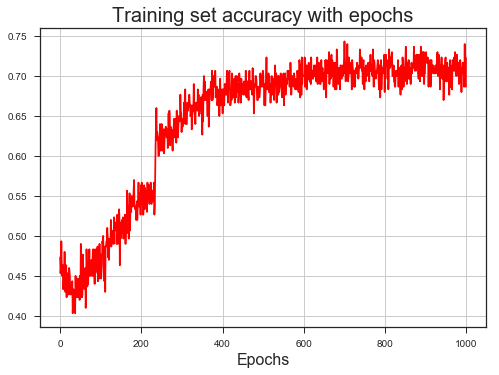

In [228]:
hist=run_NN(nn_model,X_train_scaled,y_train_scaled,verbosity=1,batch_size=16,
            num_epochs=1000,plot_loss=True)

In [229]:
score=test_NN(hist,X_test_scaled,y_test_scaled)
print("1-layer NN (using backpropagation) accuracy: ",score)

1-layer NN (using backpropagation) accuracy:  0.76


### Run 2-layer model with more neurons

In [241]:
nn_model2=make_2layer_NN(input_dim=input_dim,num_classes=num_classes,dropout_prob=0.2,learning_rate=0.0001,
                      neuron_layer_1=50,neuron_layer_2=25,optimizer='Adam')

Epoch 1/1000
300/300 [==============================] - 1s 4ms/step - loss: 0.7065 - acc: 0.4433
Epoch 2/1000
300/300 [==============================] - 0s 156us/step - loss: 0.7187 - acc: 0.4600
Epoch 3/1000
300/300 [==============================] - 0s 146us/step - loss: 0.7050 - acc: 0.5033
Epoch 4/1000
300/300 [==============================] - 0s 143us/step - loss: 0.7033 - acc: 0.4967
Epoch 5/1000
300/300 [==============================] - 0s 156us/step - loss: 0.7006 - acc: 0.5200
Epoch 6/1000
300/300 [==============================] - 0s 153us/step - loss: 0.6944 - acc: 0.5167
Epoch 7/1000
300/300 [==============================] - 0s 179us/step - loss: 0.6852 - acc: 0.4800
Epoch 8/1000
300/300 [==============================] - 0s 153us/step - loss: 0.6973 - acc: 0.5333
Epoch 9/1000
300/300 [==============================] - 0s 159us/step - loss: 0.6643 - acc: 0.5433
Epoch 10/1000
300/300 [==============================] - 0s 150us/step - loss: 0.6723 - acc: 0.5400
Epoch 11/10

Epoch 82/1000
300/300 [==============================] - 0s 166us/step - loss: 0.5256 - acc: 0.7433
Epoch 83/1000
300/300 [==============================] - 0s 189us/step - loss: 0.4939 - acc: 0.7767
Epoch 84/1000
300/300 [==============================] - 0s 133us/step - loss: 0.5131 - acc: 0.7500
Epoch 85/1000
300/300 [==============================] - 0s 133us/step - loss: 0.5134 - acc: 0.7433
Epoch 86/1000
300/300 [==============================] - 0s 130us/step - loss: 0.5052 - acc: 0.7567
Epoch 87/1000
300/300 [==============================] - 0s 140us/step - loss: 0.5288 - acc: 0.7300
Epoch 88/1000
300/300 [==============================] - 0s 143us/step - loss: 0.5124 - acc: 0.7167
Epoch 89/1000
300/300 [==============================] - 0s 137us/step - loss: 0.5001 - acc: 0.7633
Epoch 90/1000
300/300 [==============================] - 0s 146us/step - loss: 0.5162 - acc: 0.7633
Epoch 91/1000
300/300 [==============================] - 0s 146us/step - loss: 0.5092 - acc: 0.7667


300/300 [==============================] - 0s 146us/step - loss: 0.4519 - acc: 0.7900
Epoch 164/1000
300/300 [==============================] - 0s 137us/step - loss: 0.4476 - acc: 0.8000
Epoch 165/1000
300/300 [==============================] - 0s 140us/step - loss: 0.4278 - acc: 0.8200
Epoch 166/1000
300/300 [==============================] - 0s 150us/step - loss: 0.4282 - acc: 0.8267
Epoch 167/1000
300/300 [==============================] - 0s 127us/step - loss: 0.4517 - acc: 0.7833
Epoch 168/1000
300/300 [==============================] - 0s 140us/step - loss: 0.4399 - acc: 0.8100
Epoch 169/1000
300/300 [==============================] - 0s 130us/step - loss: 0.4493 - acc: 0.7733
Epoch 170/1000
300/300 [==============================] - 0s 130us/step - loss: 0.4376 - acc: 0.8100
Epoch 171/1000
300/300 [==============================] - 0s 150us/step - loss: 0.4186 - acc: 0.8400
Epoch 172/1000
300/300 [==============================] - 0s 140us/step - loss: 0.4297 - acc: 0.8100
Epoch

300/300 [==============================] - 0s 156us/step - loss: 0.3868 - acc: 0.8367
Epoch 244/1000
300/300 [==============================] - 0s 156us/step - loss: 0.4007 - acc: 0.8000
Epoch 245/1000
300/300 [==============================] - 0s 172us/step - loss: 0.4159 - acc: 0.8100
Epoch 246/1000
300/300 [==============================] - 0s 153us/step - loss: 0.4009 - acc: 0.8200
Epoch 247/1000
300/300 [==============================] - 0s 163us/step - loss: 0.3631 - acc: 0.8333
Epoch 248/1000
300/300 [==============================] - 0s 143us/step - loss: 0.3950 - acc: 0.8233
Epoch 249/1000
300/300 [==============================] - 0s 163us/step - loss: 0.3785 - acc: 0.8267
Epoch 250/1000
300/300 [==============================] - 0s 143us/step - loss: 0.3771 - acc: 0.8233
Epoch 251/1000
300/300 [==============================] - 0s 143us/step - loss: 0.3894 - acc: 0.8233
Epoch 252/1000
300/300 [==============================] - 0s 163us/step - loss: 0.3875 - acc: 0.8367
Epoch

300/300 [==============================] - 0s 140us/step - loss: 0.3424 - acc: 0.8767
Epoch 325/1000
300/300 [==============================] - 0s 159us/step - loss: 0.3554 - acc: 0.8533
Epoch 326/1000
300/300 [==============================] - 0s 143us/step - loss: 0.3720 - acc: 0.8400
Epoch 327/1000
300/300 [==============================] - 0s 150us/step - loss: 0.3652 - acc: 0.8500
Epoch 328/1000
300/300 [==============================] - 0s 140us/step - loss: 0.3401 - acc: 0.8567
Epoch 329/1000
300/300 [==============================] - 0s 140us/step - loss: 0.3821 - acc: 0.8400
Epoch 330/1000
300/300 [==============================] - 0s 153us/step - loss: 0.3412 - acc: 0.8433
Epoch 331/1000
300/300 [==============================] - 0s 176us/step - loss: 0.3504 - acc: 0.8433
Epoch 332/1000
300/300 [==============================] - 0s 199us/step - loss: 0.3312 - acc: 0.8667
Epoch 333/1000
300/300 [==============================] - 0s 218us/step - loss: 0.3603 - acc: 0.8300
Epoch

300/300 [==============================] - 0s 176us/step - loss: 0.3554 - acc: 0.8467
Epoch 406/1000
300/300 [==============================] - 0s 215us/step - loss: 0.3347 - acc: 0.8700
Epoch 407/1000
300/300 [==============================] - 0s 221us/step - loss: 0.3280 - acc: 0.8500
Epoch 408/1000
300/300 [==============================] - 0s 221us/step - loss: 0.3374 - acc: 0.8700
Epoch 409/1000
300/300 [==============================] - 0s 241us/step - loss: 0.3260 - acc: 0.8467
Epoch 410/1000
300/300 [==============================] - 0s 260us/step - loss: 0.3253 - acc: 0.8667
Epoch 411/1000
300/300 [==============================] - 0s 241us/step - loss: 0.3433 - acc: 0.8533
Epoch 412/1000
300/300 [==============================] - 0s 283us/step - loss: 0.3363 - acc: 0.8333
Epoch 413/1000
300/300 [==============================] - 0s 286us/step - loss: 0.3648 - acc: 0.8433
Epoch 414/1000
300/300 [==============================] - 0s 189us/step - loss: 0.3090 - acc: 0.8567
Epoch

300/300 [==============================] - 0s 146us/step - loss: 0.3111 - acc: 0.8733
Epoch 487/1000
300/300 [==============================] - 0s 133us/step - loss: 0.3141 - acc: 0.8700
Epoch 488/1000
300/300 [==============================] - 0s 143us/step - loss: 0.2836 - acc: 0.8933
Epoch 489/1000
300/300 [==============================] - 0s 143us/step - loss: 0.3034 - acc: 0.8633
Epoch 490/1000
300/300 [==============================] - ETA: 0s - loss: 0.3015 - acc: 0.937 - 0s 143us/step - loss: 0.3139 - acc: 0.8600
Epoch 491/1000
300/300 [==============================] - 0s 140us/step - loss: 0.3138 - acc: 0.8600
Epoch 492/1000
300/300 [==============================] - 0s 137us/step - loss: 0.3095 - acc: 0.8700
Epoch 493/1000
300/300 [==============================] - 0s 130us/step - loss: 0.3182 - acc: 0.8733
Epoch 494/1000
300/300 [==============================] - 0s 127us/step - loss: 0.2895 - acc: 0.8933
Epoch 495/1000
300/300 [==============================] - 0s 137us/s

300/300 [==============================] - 0s 137us/step - loss: 0.2719 - acc: 0.8800
Epoch 567/1000
300/300 [==============================] - 0s 159us/step - loss: 0.2887 - acc: 0.8700
Epoch 568/1000
300/300 [==============================] - 0s 143us/step - loss: 0.2882 - acc: 0.8900
Epoch 569/1000
300/300 [==============================] - 0s 163us/step - loss: 0.3138 - acc: 0.8600
Epoch 570/1000
300/300 [==============================] - 0s 150us/step - loss: 0.2968 - acc: 0.8767
Epoch 571/1000
300/300 [==============================] - 0s 143us/step - loss: 0.3028 - acc: 0.8767
Epoch 572/1000
300/300 [==============================] - 0s 172us/step - loss: 0.3029 - acc: 0.8867
Epoch 573/1000
300/300 [==============================] - 0s 169us/step - loss: 0.2749 - acc: 0.8833
Epoch 574/1000
300/300 [==============================] - 0s 176us/step - loss: 0.2904 - acc: 0.8667
Epoch 575/1000
300/300 [==============================] - 0s 172us/step - loss: 0.2920 - acc: 0.8667
Epoch

300/300 [==============================] - 0s 133us/step - loss: 0.3132 - acc: 0.8733
Epoch 647/1000
300/300 [==============================] - 0s 146us/step - loss: 0.2753 - acc: 0.9100
Epoch 648/1000
300/300 [==============================] - 0s 137us/step - loss: 0.2703 - acc: 0.8900
Epoch 649/1000
300/300 [==============================] - 0s 140us/step - loss: 0.2804 - acc: 0.8767
Epoch 650/1000
300/300 [==============================] - 0s 130us/step - loss: 0.2745 - acc: 0.8833
Epoch 651/1000
300/300 [==============================] - 0s 137us/step - loss: 0.3080 - acc: 0.8667
Epoch 652/1000
300/300 [==============================] - 0s 127us/step - loss: 0.2706 - acc: 0.8933
Epoch 653/1000
300/300 [==============================] - 0s 130us/step - loss: 0.2848 - acc: 0.9000
Epoch 654/1000
300/300 [==============================] - 0s 133us/step - loss: 0.2737 - acc: 0.8800
Epoch 655/1000
300/300 [==============================] - 0s 130us/step - loss: 0.2805 - acc: 0.9100
Epoch

300/300 [==============================] - 0s 150us/step - loss: 0.2543 - acc: 0.8967
Epoch 728/1000
300/300 [==============================] - 0s 150us/step - loss: 0.2672 - acc: 0.8800
Epoch 729/1000
300/300 [==============================] - 0s 133us/step - loss: 0.2554 - acc: 0.8867
Epoch 730/1000
300/300 [==============================] - 0s 143us/step - loss: 0.2693 - acc: 0.8833
Epoch 731/1000
300/300 [==============================] - 0s 127us/step - loss: 0.2796 - acc: 0.8933
Epoch 732/1000
300/300 [==============================] - 0s 137us/step - loss: 0.2585 - acc: 0.8900
Epoch 733/1000
300/300 [==============================] - 0s 130us/step - loss: 0.2809 - acc: 0.8867
Epoch 734/1000
300/300 [==============================] - 0s 146us/step - loss: 0.2626 - acc: 0.9000
Epoch 735/1000
300/300 [==============================] - 0s 133us/step - loss: 0.2743 - acc: 0.8933
Epoch 736/1000
300/300 [==============================] - 0s 133us/step - loss: 0.2943 - acc: 0.8700
Epoch

300/300 [==============================] - 0s 166us/step - loss: 0.2422 - acc: 0.9100
Epoch 809/1000
300/300 [==============================] - 0s 176us/step - loss: 0.2537 - acc: 0.8833
Epoch 810/1000
300/300 [==============================] - 0s 156us/step - loss: 0.2505 - acc: 0.8933
Epoch 811/1000
300/300 [==============================] - 0s 153us/step - loss: 0.2726 - acc: 0.8867
Epoch 812/1000
300/300 [==============================] - 0s 153us/step - loss: 0.2692 - acc: 0.8933
Epoch 813/1000
300/300 [==============================] - 0s 150us/step - loss: 0.2604 - acc: 0.8967
Epoch 814/1000
300/300 [==============================] - 0s 169us/step - loss: 0.2679 - acc: 0.8867
Epoch 815/1000
300/300 [==============================] - 0s 156us/step - loss: 0.2460 - acc: 0.9067
Epoch 816/1000
300/300 [==============================] - 0s 163us/step - loss: 0.2855 - acc: 0.8867
Epoch 817/1000
300/300 [==============================] - 0s 153us/step - loss: 0.2665 - acc: 0.8767
Epoch

300/300 [==============================] - 0s 150us/step - loss: 0.2540 - acc: 0.8967
Epoch 890/1000
300/300 [==============================] - 0s 146us/step - loss: 0.2310 - acc: 0.8900
Epoch 891/1000
300/300 [==============================] - 0s 133us/step - loss: 0.2599 - acc: 0.8933
Epoch 892/1000
300/300 [==============================] - 0s 140us/step - loss: 0.2438 - acc: 0.9100
Epoch 893/1000
300/300 [==============================] - 0s 133us/step - loss: 0.2193 - acc: 0.9100
Epoch 894/1000
300/300 [==============================] - 0s 130us/step - loss: 0.2567 - acc: 0.8900
Epoch 895/1000
300/300 [==============================] - 0s 130us/step - loss: 0.2295 - acc: 0.9167
Epoch 896/1000
300/300 [==============================] - 0s 133us/step - loss: 0.2730 - acc: 0.8733
Epoch 897/1000
300/300 [==============================] - 0s 130us/step - loss: 0.2432 - acc: 0.9000
Epoch 898/1000
300/300 [==============================] - 0s 133us/step - loss: 0.2374 - acc: 0.9100
Epoch

300/300 [==============================] - 0s 215us/step - loss: 0.2375 - acc: 0.9033
Epoch 970/1000
300/300 [==============================] - 0s 208us/step - loss: 0.1996 - acc: 0.9267
Epoch 971/1000
300/300 [==============================] - 0s 260us/step - loss: 0.2640 - acc: 0.8933
Epoch 972/1000
300/300 [==============================] - 0s 247us/step - loss: 0.2512 - acc: 0.8900
Epoch 973/1000
300/300 [==============================] - 0s 244us/step - loss: 0.2261 - acc: 0.9133
Epoch 974/1000
300/300 [==============================] - 0s 199us/step - loss: 0.2409 - acc: 0.9033
Epoch 975/1000
300/300 [==============================] - 0s 176us/step - loss: 0.2530 - acc: 0.8867
Epoch 976/1000
300/300 [==============================] - 0s 172us/step - loss: 0.2365 - acc: 0.8700
Epoch 977/1000
300/300 [==============================] - 0s 172us/step - loss: 0.2400 - acc: 0.8967
Epoch 978/1000
300/300 [==============================] - 0s 169us/step - loss: 0.2125 - acc: 0.9100
Epoch

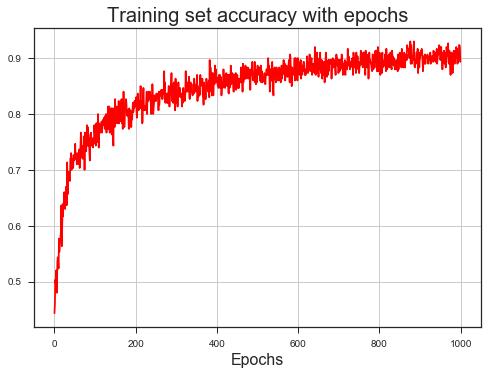

In [242]:
hist2=run_NN(nn_model2,X_train_scaled,y_train_scaled,verbosity=1,batch_size=16,
            num_epochs=1000,plot_loss=True)

In [243]:
score=test_NN(hist2,X_test_scaled,y_test_scaled)
print("2-layer NN with more neurons per layer (using backpropagation) accuracy: ",score)

2-layer NN with more neurons per layer (using backpropagation) accuracy:  0.825
